# Project: Predicting Insurance

## Importing dataset & library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Upload Dataset

In [2]:
df = pd.read_excel('Z:\ML\Predicting_insurance\premiums.xlsx')
df.head(2)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [3]:
# show rows and columns
df.shape 

(50000, 13)

In [4]:
# convert columns into single format
df.columns = df.columns.str.replace(' ','_').str.lower() 
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [5]:
# provides a summary of statistics for your DataFrame’s numerical columns
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.593480,1.712080,23.018200,15768.116320
std,15.000437,1.498248,24.219197,8419.839675
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22275.250000
max,356.000000,5.000000,930.000000,43471.000000


# Feature Engineering

In [6]:
# check null values
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [7]:
# remove null values
df.dropna(inplace=True)

In [8]:
# check duplicate values
df.duplicated().sum()

0

In [9]:
# it shows number of dtype and null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49976 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    49976 non-null  int64 
 1   gender                 49976 non-null  object
 2   region                 49976 non-null  object
 3   marital_status         49976 non-null  object
 4   number_of_dependants   49976 non-null  int64 
 5   bmi_category           49976 non-null  object
 6   smoking_status         49976 non-null  object
 7   employment_status      49976 non-null  object
 8   income_level           49976 non-null  object
 9   income_lakhs           49976 non-null  int64 
 10  medical_history        49976 non-null  object
 11  insurance_plan         49976 non-null  object
 12  annual_premium_amount  49976 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.3+ MB


In [10]:
df.sample(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
2125,48,Female,Southwest,Married,3,Obesity,No Smoking,Freelancer,25L - 40L,33,No Disease,Silver,20596
16628,57,Female,Southwest,Married,2,Normal,No Smoking,Self-Employed,<10L,2,High blood pressure,Silver,18678


In [11]:
df['number_of_dependants'].unique()

array([ 0,  2,  3,  4,  1,  5, -3, -1], dtype=int64)

In [12]:
# number_of_dependants less than 0
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [13]:
# no of values those are less than 0
df[df['number_of_dependants']<0].shape 

(72, 13)

In [14]:
# basis on the data and discussion we use that data 
df['number_of_dependants'] = df['number_of_dependants'].abs()

In [15]:
df['number_of_dependants'].value_counts()

number_of_dependants
0    15428
3    11038
1     8716
2     8418
4     4723
5     1653
Name: count, dtype: int64

In [16]:
# show numeric columns into chart
numeric_columns = df.select_dtypes(include=['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

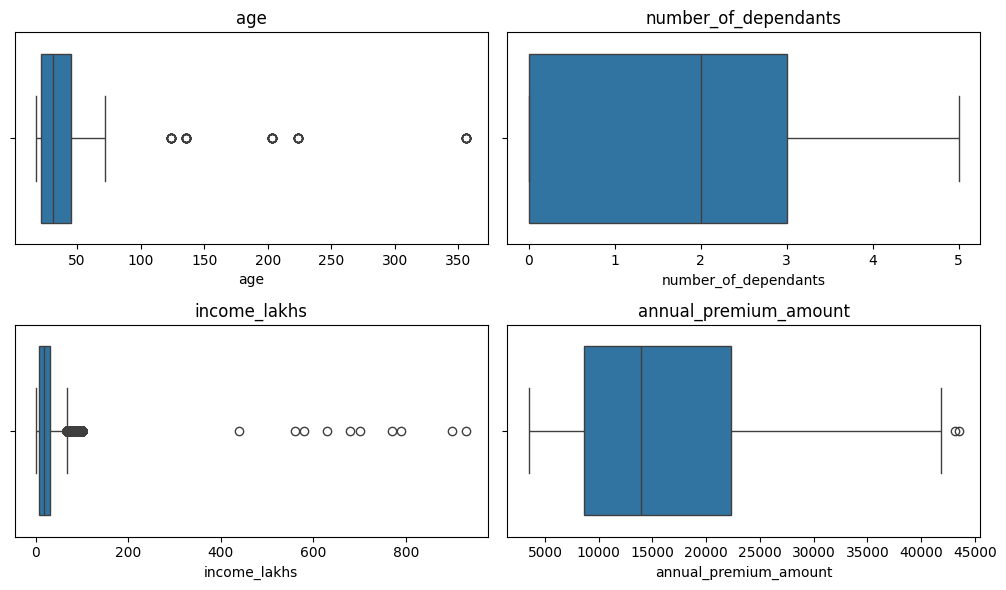

In [17]:
#used gpt to show columns side by side in 2x2 grid
import seaborn as sns
import matplotlib.pyplot as plt

# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Loop through your numeric columns
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)

plt.tight_layout()
plt.show()


## Outliers Treatment: Age Columns

In [18]:
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [19]:
# copy save the data
df1 = df[df['age']<=100].copy() 

## Outliers Treatment: Income Columns

In [20]:
def get_iqr_bound(col):
    Q1,Q3 = col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

lower,upper = get_iqr_bound(df['income_lakhs'])
lower,upper

(-29.0, 67.0)

In [21]:
df[df['income_lakhs']>upper].shape
# upper data is big 

(3560, 13)

In [22]:
# after discussing with the teams
# returns the value below which 99.9% of the data falls
quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold
# 100 = 1cr

100.0

In [23]:
# remove 10 values is better than 3000 values
df1[df1['income_lakhs']>quantile_threshold].shape

(10, 13)

In [24]:
df2 = df1[df1['income_lakhs']<=quantile_threshold].copy()
df2.shape

(49908, 13)

In [25]:
num_cols = df.select_dtypes(include=['int64']).columns
num_cols

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

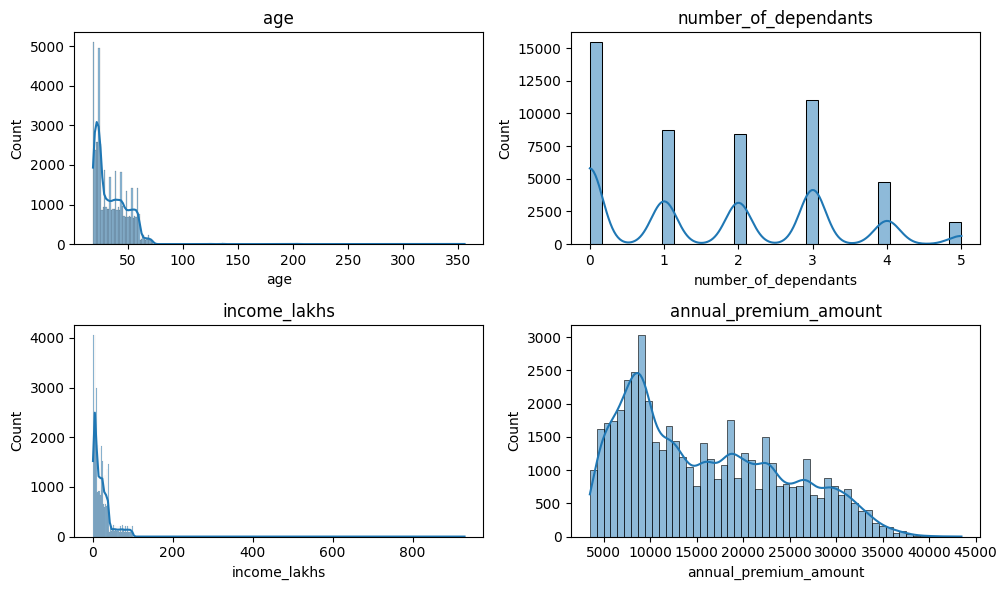

In [26]:
# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Loop through your numeric columns
for i, col in enumerate(num_cols):
    sns.histplot(x=df[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)

plt.tight_layout()
plt.show()


## Bivariate Analysis: Numeric Columns

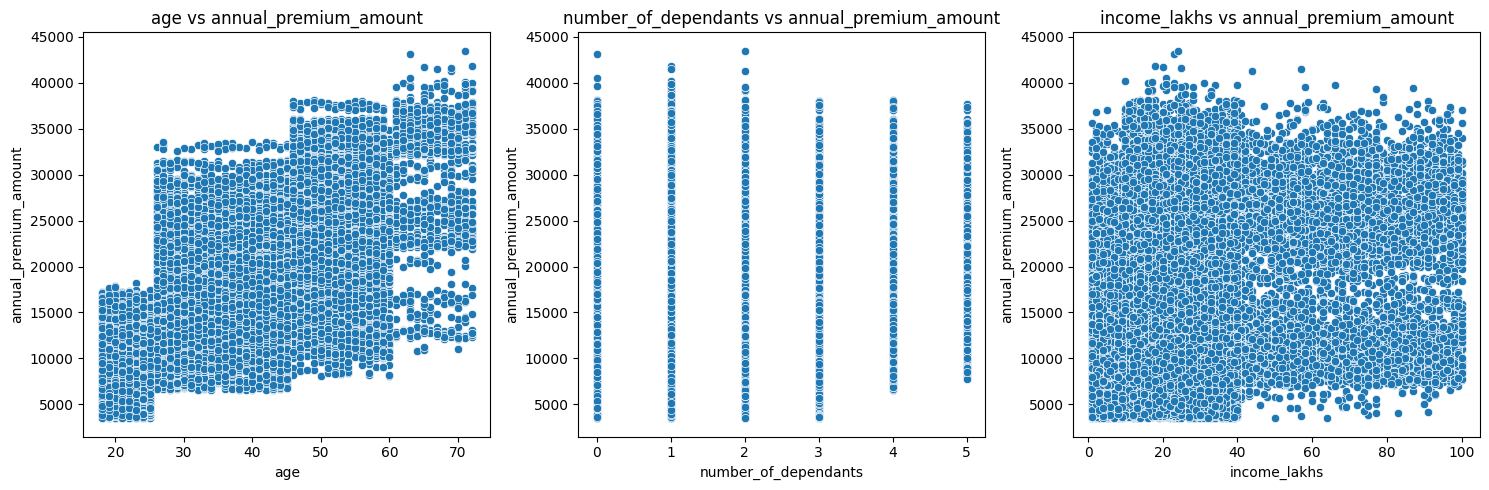

In [27]:
# show scatter plot on numerical values
count = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in num_cols:
    sns.scatterplot(ax=axes[count], x=df2[i], y=df2['annual_premium_amount'])
    axes[count].set_title(f'{i} vs annual_premium_amount')
    count += 1
    if count == 3:
        break
plt.tight_layout()
plt.show()


## Categorical Columns

In [28]:
# shows unique values for each columns
categorical_columns = df2.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(col,':',df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [29]:
df2['smoking_status'] = df2['smoking_status'].replace({'Smoking=0':'No Smoking', 
                                                       'Does Not Smoke':'No Smoking',
                                                       'Not Smoking':'No Smoking'})
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [30]:
df2['income_level'] = df2['income_level'].replace({'> 40L':'>40L'})

## Univariate Analysis

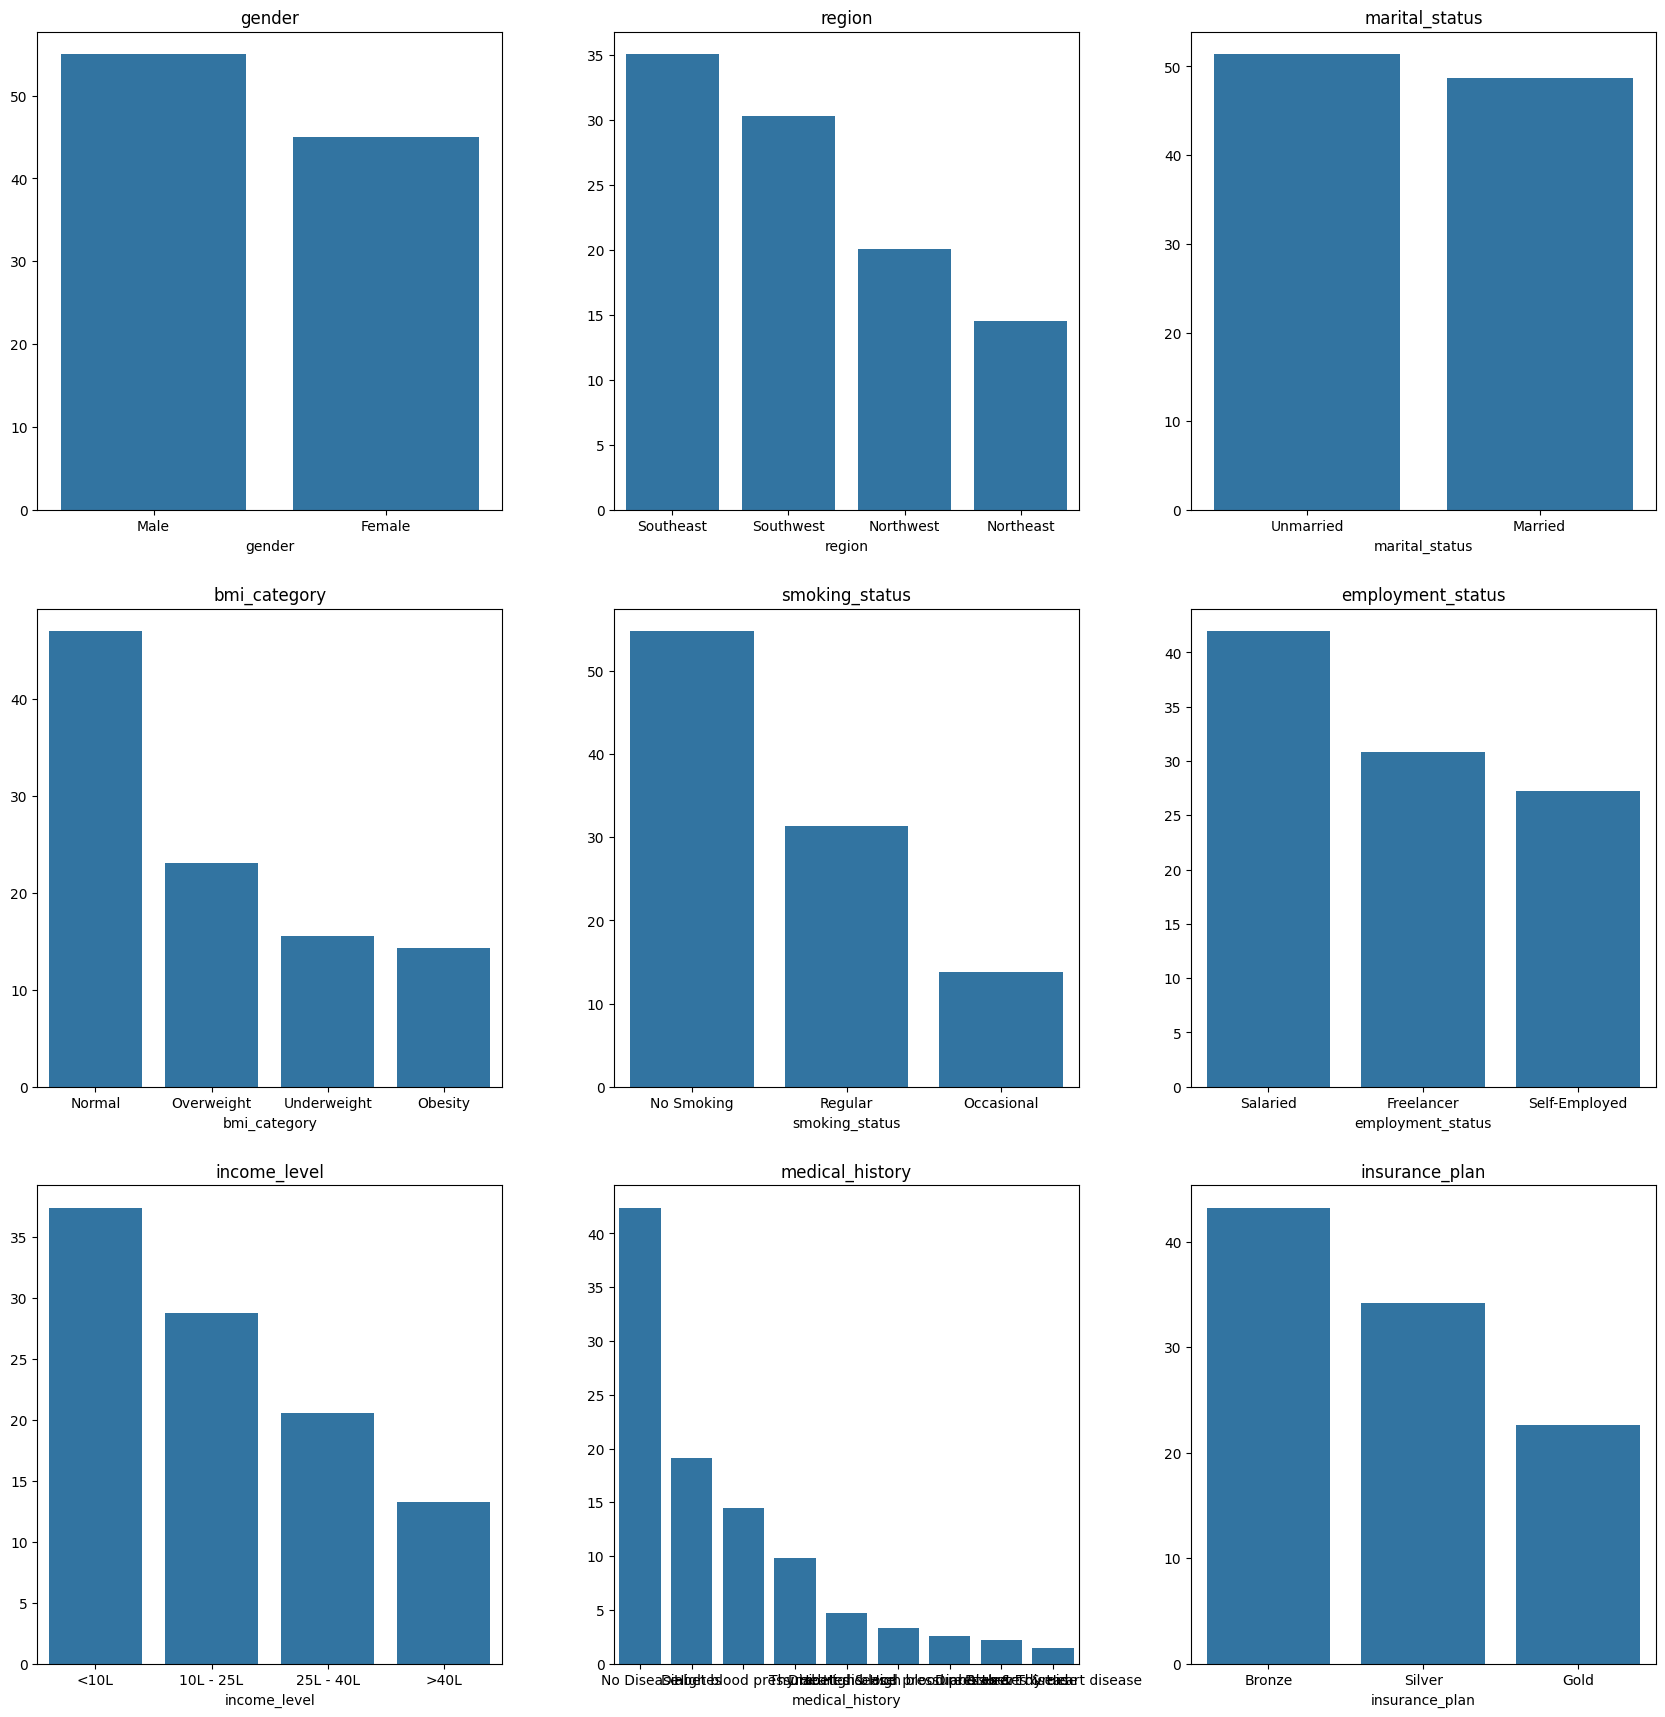

In [31]:
# one variable analysis 
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.tight_layout(pad=5.0)
count = 0
for i in categorical_columns:
    if count == 9:
        break
    categ_count = df2[i].value_counts(normalize=True) * 100
    sns.barplot(ax=axes[count // 3, count % 3], x=categ_count.index, y=categ_count.values)
    axes[count // 3, count % 3].set_title(i)
    count += 1
plt.show()

## Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
>40L               329  3653    2641


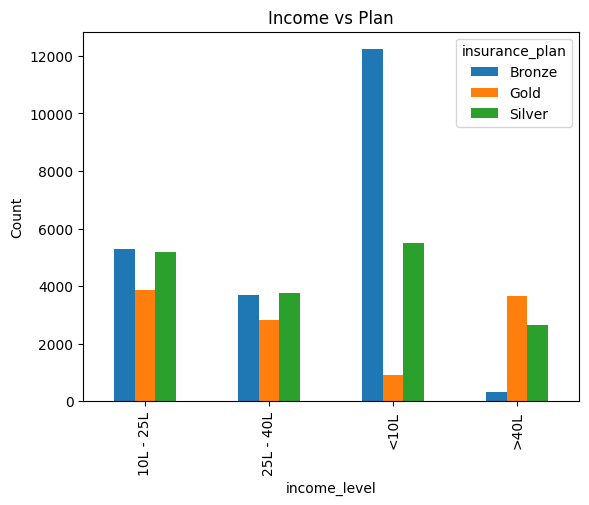

In [32]:
#Cross tabulation of gender & smoking status
crosstab = pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

# Feature Engineering 2

## Calculate risk score

In [33]:
df1['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [34]:
disease_score = {'diabetes': 6,
                 'heart disease': 8,
                 'high blood pressure': 6,
                 'thyroid': 5,
                 'no disease': 0,
                 'none': 0
}

In [35]:
df2[['disease1','disease2']] = df2['medical_history'].str.split(' & ',expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

In [36]:
for disease in ['disease1','disease2']:
    df2['total_risk_score'] += df2[disease].map(disease_score)

In [37]:
# normalize the disease score from 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalise_disease_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)

In [38]:
# normalize the data put 0 and 1 for gender
df3 = df2.copy()
df3['gender'] = df2['gender'].map({'Male':1,'Female':0}).copy()

In [39]:
# normalize the data put 0 and 1 for marital_status
df3['marital_status'] = df3['marital_status'].map({'Unmarried':1,'Married':0})

In [40]:
# drop unecessary columns
df3 = df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)

In [41]:
df3.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalise_disease_score
0,26,1,Northwest,1,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,0.428571
1,29,0,Southeast,0,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,0.428571


In [42]:
# Nominal columns = region = get_dummies
# ordinal columns = bmi_category,smoking_status,insurance_plan,income_level = labelencoder

In [43]:
df3 = pd.get_dummies(data=df3,columns=["region"],drop_first=True,dtype=int).copy()

In [44]:
df3 = pd.get_dummies(data=df3,columns=["employment_status"],drop_first=True,dtype=int).copy()

In [45]:
df3.head(2)

,age,gender,marital_status,number_of_dependants,bmi_category,smoking_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalise_disease_score,region_Northwest,region_Southeast,region_Southwest,employment_status_Salaried,employment_status_Self-Employed
0,26,1,1,0,Normal,No Smoking,<10L,6,Bronze,9053,0.428571,1,0,0,1,0
1,29,0,0,2,Obesity,Regular,<10L,6,Bronze,16339,0.428571,0,1,0,1,0


In [46]:
ordinal_column = ['bmi_category','smoking_status','insurance_plan','income_level']
cat1 = ['Underweight','Normal','Overweight','Obesity']
cat2 = ['No Smoking','Occasional','Regular']
cat3 = ['Bronze', 'Silver', 'Gold']
cat4 = ['<10L', '10L - 25L','25L - 40L', '>40L']
category_col = [cat1,cat2,cat3,cat4]

from sklearn.preprocessing import OrdinalEncoder

for col,catg in zip(ordinal_column,category_col):
    enc = OrdinalEncoder(categories=[catg])
    df3[col] = enc.fit_transform(df3[[col]]).astype(int).copy()
df3

,age,gender,marital_status,number_of_dependants,bmi_category,smoking_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalise_disease_score,region_Northwest,region_Southeast,region_Southwest,employment_status_Salaried,employment_status_Self-Employed
0,26,1,1,0,1,0,0,6,0,9053,0.428571,1,0,0,1,0
1,29,0,0,2,3,2,0,6,0,16339,0.428571,0,1,0,1,0
2,49,0,0,2,1,0,1,20,1,18164,0.428571,0,0,0,0,1
3,30,0,0,3,1,0,3,77,2,20303,0.000000,0,1,0,1,0
4,18,1,1,0,2,2,3,99,1,13365,0.428571,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,24,0,1,0,0,0,2,35,0,9111,0.000000,1,0,0,0,1
49996,47,0,0,2,1,0,3,82,2,27076,0.357143,0,1,0,1,0
49997,21,1,1,0,1,2,2,32,0,8564,0.000000,1,0,0,0,0
49998,18,1,1,2,1,0,1,20,0,9490,0.000000,1,0,0,1,0


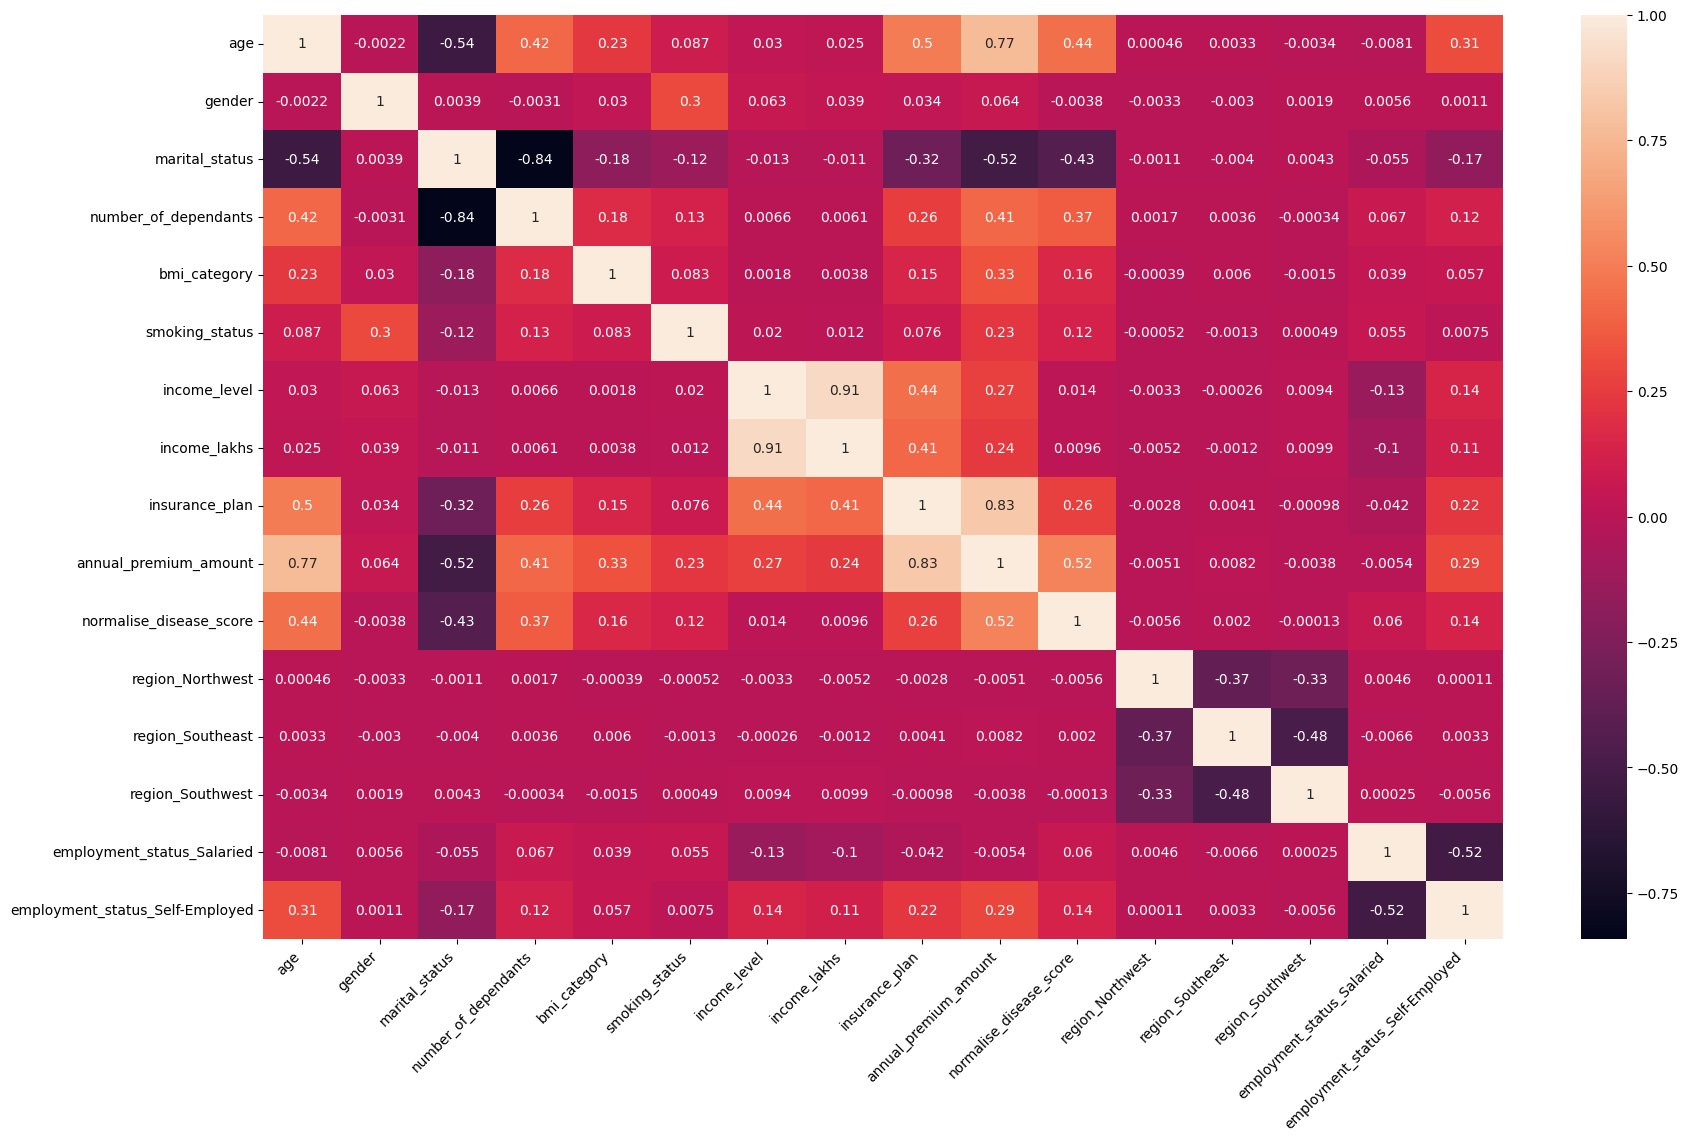

In [47]:
cm = df3.corr()
plt.figure(figsize=(20,12))
sns.heatmap(data=cm, annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.show()

# Model Building

In [48]:
X = df3.drop(columns=['annual_premium_amount'])
y = df3['annual_premium_amount']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)


In [49]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [50]:
y_pred = lr.predict(X_test)

In [51]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

MAE = mean_absolute_error(y_test,y_pred)
R2 = r2_score(y_test,y_pred)

print("MSE:",MSE)
print("RMSE:",RMSE)
print("MAE:",MAE)
print("R2:",R2)

MSE: 5435962.128023914
RMSE: 2331.5149855885365
MAE: 1808.0203087383231
R2: 0.9228530609103409


In [52]:
def get_metrics(y_test,y_pred,model_name):
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_test,y_pred)
    R2 = r2_score(y_test,y_pred)

    print(f"{model_name}:['MSE':{round(MSE,3)},'RMSE':{round(RMSE,3)},'MAE':{round(MAE,3)},'R2':{round(R2,3)}]")

In [53]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [54]:
rir = Ridge().fit(X_train,y_train)
y_pred_rir = rir.predict(X_test)

lar = Lasso().fit(X_train,y_train)
y_pred_lar = lar.predict(X_test)

poly = PolynomialFeatures(2)
x_train_poly = poly.fit_transform(X_train)
x_test_poly = poly.fit_transform(X_test)

poly_r = LinearRegression().fit(x_train_poly,y_train)
y_pred_poly = poly_r.predict(x_test_poly)

svr = SVR().fit(X_train,y_train)
y_pred_svr = svr.predict(X_test)

knnr = KNeighborsRegressor().fit(X_train,y_train)
y_pred_knnr = knnr.predict(X_test)

dtr = DecisionTreeRegressor().fit(X_train,y_train)
y_pred_dtr = dtr.predict(X_test)

rfr = RandomForestRegressor().fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

xgb = XGBRegressor().fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

In [55]:
get_metrics(y_test,y_pred_rir,"Ridge")
get_metrics(y_test,y_pred_lar,"Lasso")
get_metrics(y_test,y_pred_poly,"PolynomialFeatures")
get_metrics(y_test,y_pred_svr,"SVR")
get_metrics(y_test,y_pred_knnr,"KNeighborsRegressor")
get_metrics(y_test,y_pred_dtr,"DecisionTreeRegressor")
get_metrics(y_test,y_pred_rfr,"RandomForestRegressor")
get_metrics(y_test,y_pred_rfr,"XGBRegressor")

Ridge:['MSE':5435948.349,'RMSE':2331.512,'MAE':1808.062,'R2':0.923]
Lasso:['MSE':5435960.028,'RMSE':2331.515,'MAE':1808.328,'R2':0.923]
PolynomialFeatures:['MSE':3324857.956,'RMSE':1823.419,'MAE':1430.746,'R2':0.953]
SVR:['MSE':46013526.167,'RMSE':6783.327,'MAE':5538.248,'R2':0.347]
KNeighborsRegressor:['MSE':8744498.235,'RMSE':2957.11,'MAE':2177.738,'R2':0.876]
DecisionTreeRegressor:['MSE':2585732.32,'RMSE':1608.021,'MAE':1013.515,'R2':0.963]
RandomForestRegressor:['MSE':1478768.404,'RMSE':1216.046,'MAE':802.329,'R2':0.979]
XGBRegressor:['MSE':1478768.404,'RMSE':1216.046,'MAE':802.329,'R2':0.979]


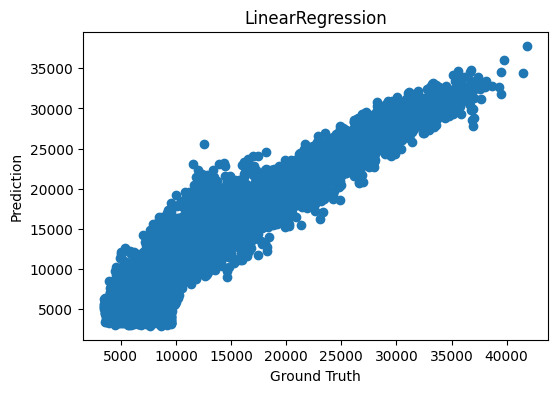

In [56]:
plt.figure(figsize=(6,4))
plt.scatter(y_test,y_pred)
plt.title("LinearRegression")
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

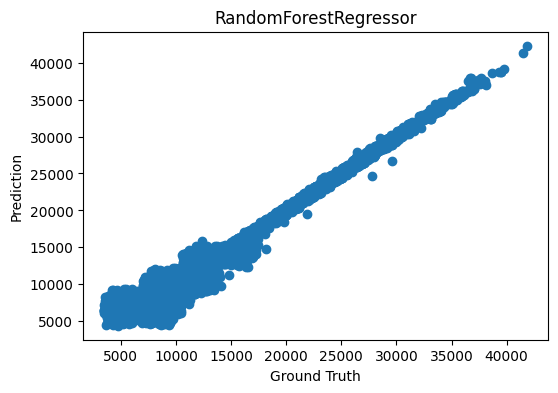

In [57]:
plt.figure(figsize=(6,4))
plt.scatter(y_test,y_pred_rfr)
plt.title("RandomForestRegressor")
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

# RandomSearchCV

In [58]:
best = {'oob_score': [True], 'n_estimators': [300], 'min_samples_split': [5], 'min_samples_leaf': [4], 'max_samples': [0.5], 'max_features': [1.0], 'max_depth': [10], 'bootstrap': [True]}
0.9815155560500752

0.9815155560500752

In [59]:
rf = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100,stop=1000,num=10)]

# Number of features to consider at every split
max_features = [0.3,0.7,1.0]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10,stop=110,num=11)]

# Number of samples
max_samples = [0.5,0.75,1.0]

# Bootstrap samples
bootstrap = [True,False]

# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,8,10,20,50,100,200]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4,10,20,50,100]

oob_score = [True]

In [64]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              'max_samples':max_samples,
              'bootstrap':bootstrap,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'oob_score':oob_score,
              'criterion':criterion
             }
print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': [0.3, 0.7, 1.0], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_samples': [0.5, 0.75, 1.0], 'bootstrap': [True, False], 'min_samples_split': [2, 4, 8, 16, 32, 64, 128], 'min_samples_leaf': [1, 2, 4, 8, 16, 32], 'oob_score': [True], 'criterion': ['mse', 'mae']}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_grid = RandomizedSearchCV(estimator = rf,n_iter=100,
                       param_distributions = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs=-1)
rf_grid.fit(X_train,y_train)
print(rf_grid.best_params_)
print(rf_grid.best_score_)

In [1074]:
input_data_model = pd.DataFrame([[27,1,0,0,1,0,0,6,0,0.8571,1,0,1,1,1]],
                               columns=['age', 'gender', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'income_level', 'income_lakhs',
       'insurance_plan', 'normalise_disease_score',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'employment_status_Salaried', 'employment_status_Self-Employed'])
input_data_model

,age,gender,marital_status,number_of_dependants,bmi_category,smoking_status,income_level,income_lakhs,insurance_plan,normalise_disease_score,region_Northwest,region_Southeast,region_Southwest,employment_status_Salaried,employment_status_Self-Employed
0,27,1,0,0,1,0,0,6,0,0.8571,1,0,1,1,1


In [1078]:
rf_grid.predict(input_data_model)

array([11307.9409921])